In [2]:
import load_ppe_fun as lp
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
import pickle
import warnings
import re
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import itertools

In [32]:
vnum='0001'
nikki = '2025-05-27'
sim_config = 'rainshaft_Vx_r1'
l_cic = True
target_simconfig = 'rainshaft_dt60'

plot_dir = 'plots/' + nikki + '/' + sim_config + '/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

n_init = 1

# obtaining case related variables
mconfigs = os.listdir(lp.output_dir + nikki)

vars_strs = lp.get_dics(lp.output_dir, 'target', target_simconfig, n_init)
mps, nmp = lp.get_mps(lp.output_dir, nikki, sim_config, l_cic, vars_strs)
mps = lp.sort_strings_by_number(mps)
# var_interest = [4, 9] # see lp.indvar_ename_set
# var_interest = [127, 128, 129, 130]
var_interest = [131, 132, 133, 134]
# var_interest = [92, 108, 123, 124, 125, 126]
# var_interest = [106, 107] # see lp.indvar_ename_set
# var_interest = [95, 107, 121, 122] # see lp.indvar_ename_set
# var_interest = [2,3,4] # see lp.indvar_ename_set
indvar_names = [lp.indvar_name_set[idx] for idx in var_interest]
indvar_enames = [lp.indvar_ename_set[idx] for idx in var_interest]
indvar_units = [lp.indvar_units_set[idx] for idx in var_interest]
vars_vn = [re.search(r'^[A-Z]*[a-z]*', istr[0])[0] for istr in vars_strs]

file_info = {'dir': lp.output_dir, 
             'date': nikki, 
             'version_number': vnum,
             'vars_vn': vars_vn}

nc_dict = {}
data_range = {}

nc_summary_pkl_fn = lp.output_dir + nikki + '/' + sim_config + '_ncs_' + str(var_interest) + '.pkl'

In [33]:
# data_range_pkl_fn = lp.output_dir + nikki + '/' + sim_config + '_dr_' + str(var_interest) + '.pkl'
if os.path.isfile(nc_summary_pkl_fn):
    with open(nc_summary_pkl_fn, 'rb') as file:
        nc_dict = pickle.load(file)
else:
    file_info.update({'sim_config': sim_config})

    # for imp, mp in enumerate(mps):
    for imp, mp in enumerate(tqdm(mps, desc='loading PPEs')):
        file_info['mp_config'] = mp
        nc_dict = lp.load_KiD(file_info, var_interest, nc_dict, data_range, continuous_ic=l_cic)[0]

    with open(nc_summary_pkl_fn, 'wb') as file:
        pickle.dump(nc_dict, file)

loading PPEs: 100%|██████████| 10000/10000 [00:16<00:00, 610.53it/s]


In [34]:
# load BIN_TAU
for combo in itertools.product(*vars_strs):
    ic_str = "".join(combo)
    file_info.update({'sim_config': target_simconfig,
                      'vars_str': list(combo),
                      'date': 'target',
                      'mp_config': 'BIN_TAU'})
    nc_dict, lin_or_log, data_range = \
            lp.load_KiD(file_info, var_interest, nc_dict, data_range, False)

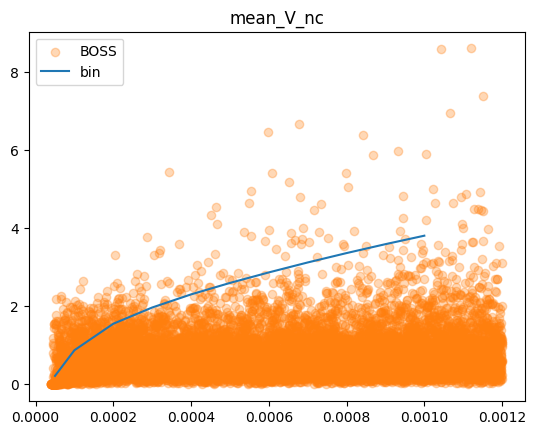

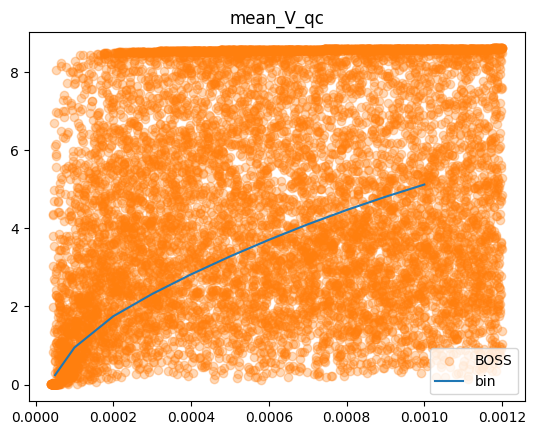

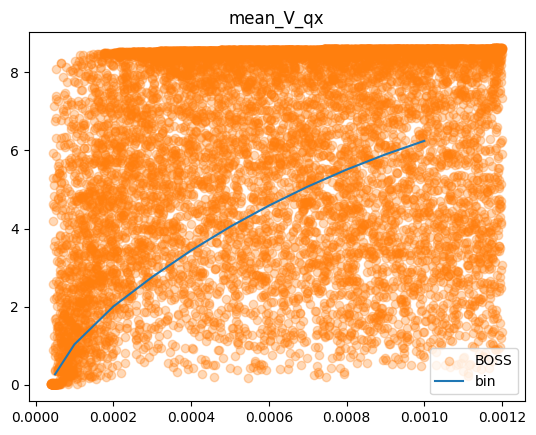

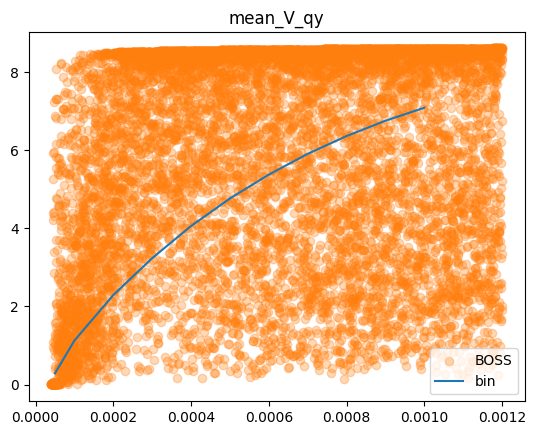

In [35]:
float_re = re.compile(r'(\d+(?:\.\d+)?)$')  # match digits, optional .digits, at end
    
def numeric_key(s):
    # Find the first sequence of digits in the string
    m = float_re.search(s)
    return float(m.group(1)) if m else 0.0

# NOTE: make sure n_init = 1 for this visualization
for var_ename in indvar_enames:
    plt.figure()
    var_interest_val = []
    ind_var_val = []

    boss_var_interest_val = []
    boss_ind_var_val = []
    for combo in itertools.product(*vars_strs):
        ic_str = "".join(combo)
        ind_var_val.append(numeric_key(combo[0]))
        var_interest_val.append(nc_dict[ic_str]['BIN_TAU'][var_ename])
    for imp, mp in enumerate(mps):
        boss_var_interest_val.append(nc_dict['cic'][mp][var_ename])
        boss_ind_var_val.append(nc_dict['cic'][mp][vars_vn[0]])
    plt.scatter(boss_ind_var_val, boss_var_interest_val, c='tab:orange', alpha=0.3, label='BOSS')
    plt.plot(ind_var_val, var_interest_val, label='bin')
    plt.legend()
    plt.title(var_ename)
    # plt.yscale('log')